## Import modules

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as sm
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

## Load and inspect the complete combined datasets

In [2]:
os.chdir('C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya')
print(os.getcwd())

C:\Apurva\Conservation Games\Games meta-analysis\Datasets\Data Gabon, Orkney, Madagascar and Kenya


In [3]:
# print number of rows in the dataset
data = pd.read_csv('combined6.csv', index_col=0)
len(data)

11949

In [4]:
data.columns

Index(['Rel3_2', 'subsidy', 'Education_2', 'RespHOH_1', 'Rel2_3', 'GameID',
       'Rel2_2', 'Age_3', 'Rel3_3', 'Treatments', 'Gender_4', 'Rel3_1',
       'country', 'Rel1_1', 'Age_4', 'Age_2', 'Education_3', 'Rel2_4',
       'Gender_1', 'Gender_2', 'Education_4', 'RespHOH_2', 'Gender_3',
       'RespHOH_4', 'Education_1', 'Rel1_4', 'Rel2_1', 'RespHOH_3', 'Age_1',
       'Rel1_3', 'Rel3_4', 'envProduction', 'Rel1_2'],
      dtype='object')

In [5]:
np.unique([x[:-2] for x in data.columns.values])

array(['Age', 'Education', 'Game', 'Gender', 'Rel1', 'Rel2', 'Rel3',
       'RespHOH', 'Treatmen', 'count', 'envProducti', 'subsi'],
      dtype='<U11')

## Compute group statistics (mean, variance, min, max)

In [6]:
for col in ['Age', 'Education', 'Gender', 'RespHOH']:
    data[col+'_mean'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].mean(axis=1)
    #data[col+'_std'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].std(axis=1)
    data[col+'_var'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].var(axis=1)
    data[col+'_min'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].min(axis=1)
    data[col+'_max'] = data[[col+'_1', col+'_2', col+'_3', col+'_4']].max(axis=1)

data['rel_mean'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].mean(axis=1)
data['rel_var'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].var(axis=1)
data['rel_min'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].min(axis=1)
data['rel_max'] = data[['Rel1_1', 'Rel2_1', 'Rel3_1', 'Rel1_2', 'Rel2_2', 'Rel3_2',
                       'Rel1_3', 'Rel2_3', 'Rel3_3', 'Rel1_4', 'Rel2_4', 'Rel3_4']].max(axis=1)

In [7]:
# Get one hot encoding of country column
one_hot = pd.get_dummies(data['country'])
# Join the encoded dataframe
data = pd.concat([data, one_hot], axis=1)

## Compute column-wise z-scores

In [8]:
col_list = ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
            'Education_mean', 'Education_max', 'Education_min', 'Education_var',
            'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
            'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy', 'envProduction']
for col in col_list:
    data['z_'+col] = data.groupby('country')[col].transform(lambda x: scale(x.astype(float)))

In [9]:
explanatory_var = ['z_' + x for x in ['Age_mean', 'Age_max', 'Age_min', 'Age_var',
                  'Education_mean', 'Education_max', 'Education_min', 'Education_var',
                  'Gender_mean', 'Gender_max', 'Gender_min', 'Gender_var',
                  'rel_mean', 'rel_var', 'rel_min', 'rel_max', 'subsidy']] #+ ['cambodia', 'gabon', 'orkney', 'tanzania', 'vietnam', 'KEN', 'MAD']

predictor_var = 'z_envProduction'

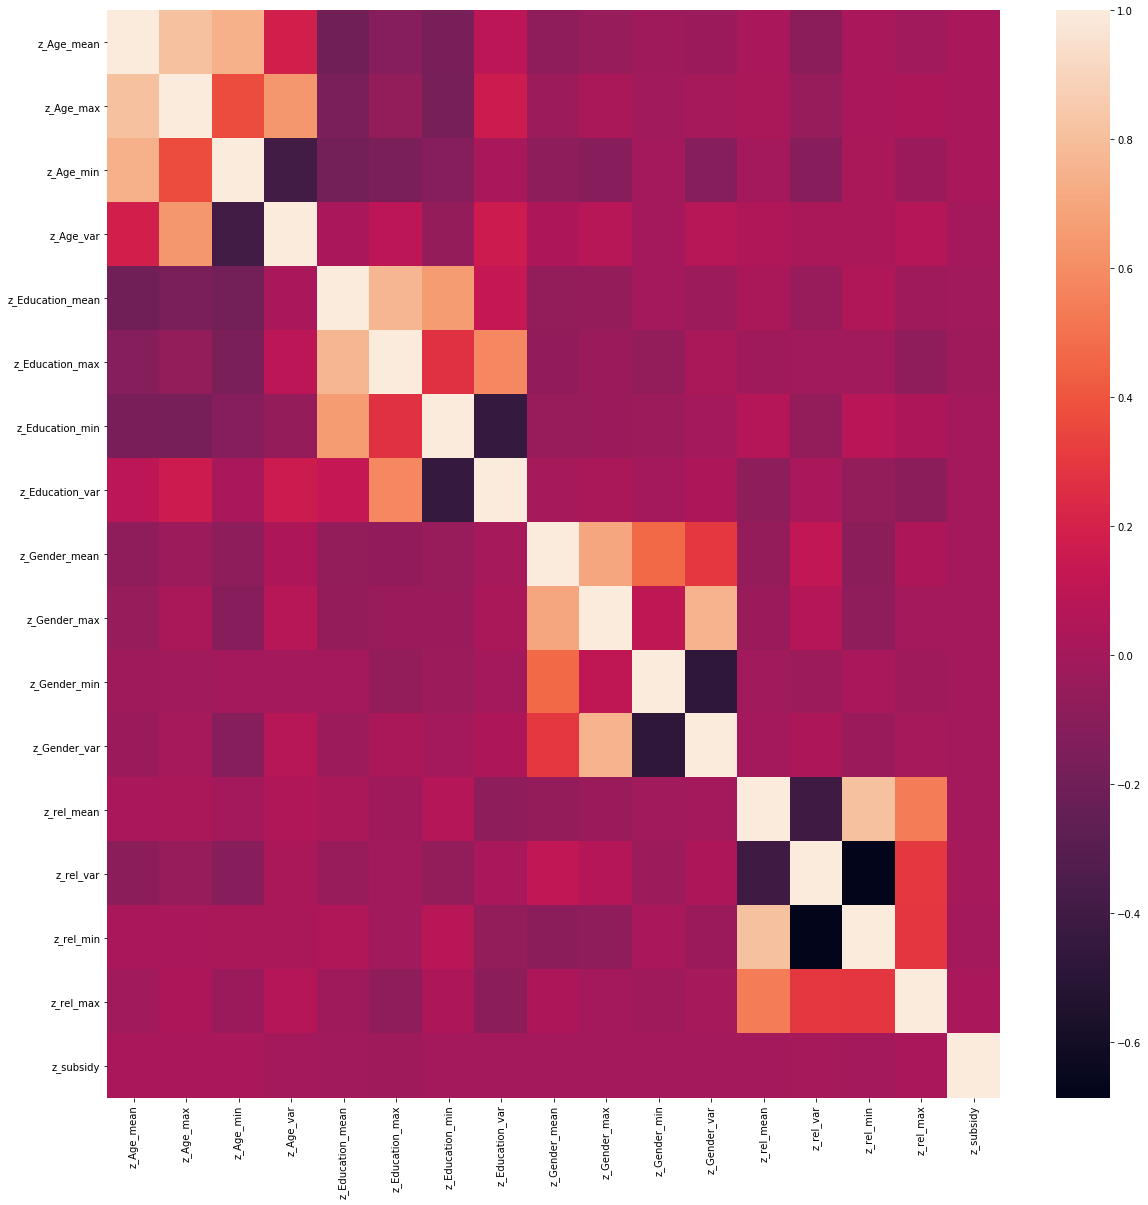

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data[explanatory_var].corr(), ax=ax)

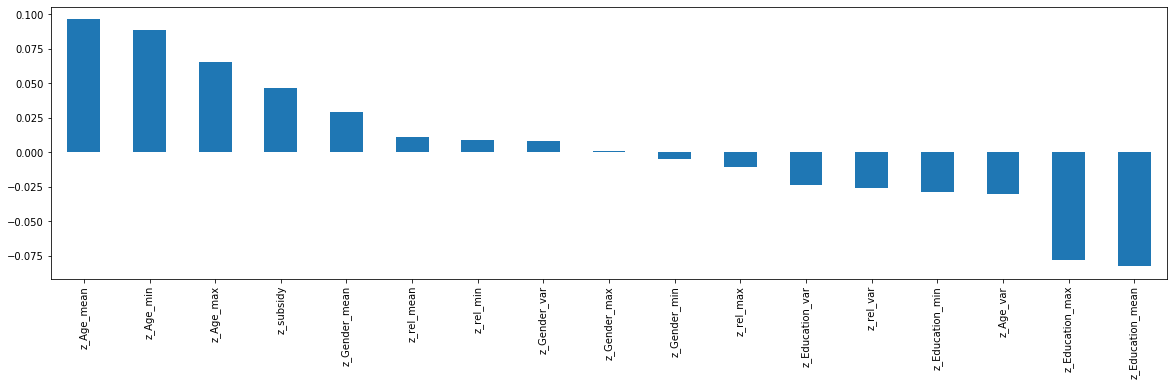

In [11]:
data[explanatory_var+[predictor_var]].corr()['z_envProduction'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20,5))

In [12]:
data[explanatory_var].corr().unstack().sort_values(ascending=False)[17:]

z_rel_mean       z_rel_min           0.813853
z_rel_min        z_rel_mean          0.813853
z_Age_max        z_Age_mean          0.811762
z_Age_mean       z_Age_max           0.811762
z_Education_max  z_Education_mean    0.766345
                                       ...   
z_Education_min  z_Education_var    -0.448093
z_Gender_min     z_Gender_var       -0.477472
z_Gender_var     z_Gender_min       -0.477472
z_rel_var        z_rel_min          -0.685730
z_rel_min        z_rel_var          -0.685730
Length: 272, dtype: float64

In [13]:
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

11949
10908


In [14]:
formula = predictor_var + ' ~ '
for var in explanatory_var:
    formula += var + ' + '
formula = formula[:-3]

In [15]:
model = sm.ols(formula, data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        z_envProduction   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     18.37
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           2.32e-55
Time:                        09:28:49   Log-Likelihood:                -14805.
No. Observations:               10908   AIC:                         2.965e+04
Df Residuals:                   10890   BIC:                         2.978e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0675      0.009  

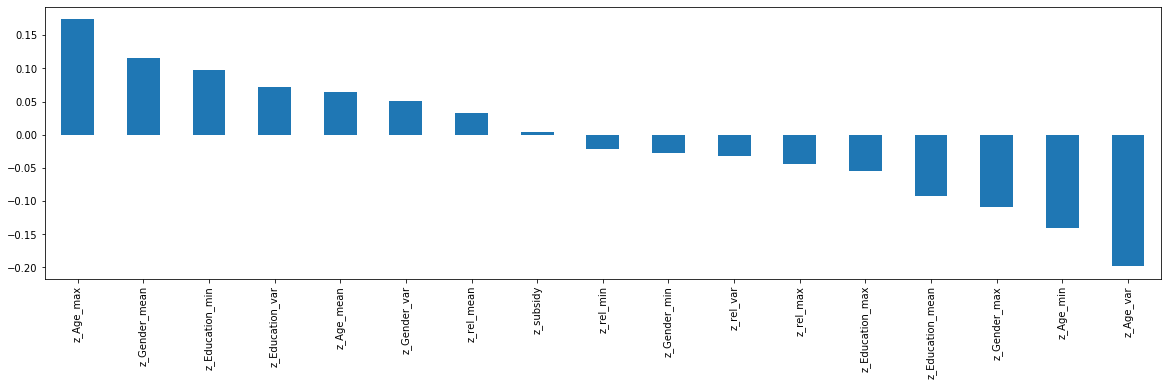

In [16]:
# plot coefficients
plt.figure(figsize=(20,5))
results.params.iloc[1:].sort_values(ascending=False).plot(kind='bar')

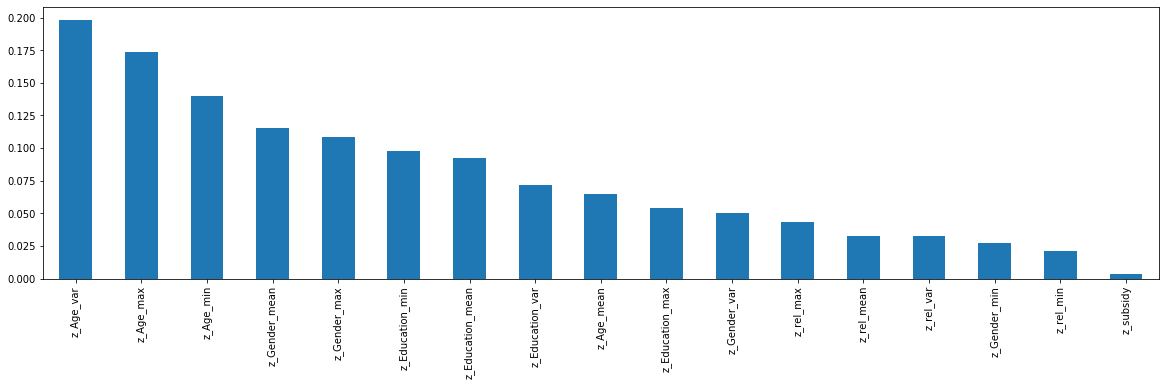

In [17]:
# plot absolute coefficients
plt.figure(figsize=(20,5))
results.params.iloc[1:].abs().sort_values(ascending=False).plot(kind='bar')

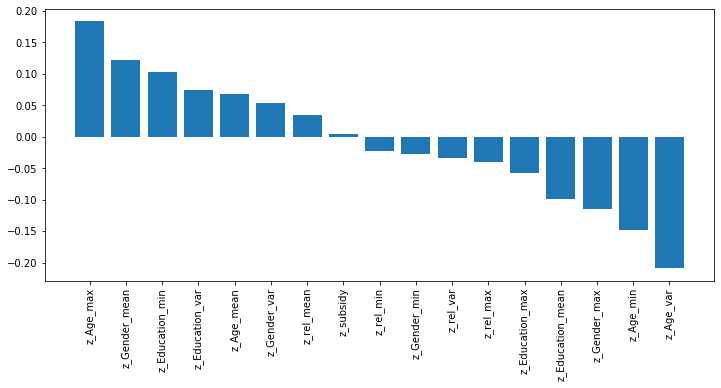

In [18]:
# plot beta coefficients
beta_coef = []
for var in results.params.index.values[1:]:
    beta_coef.append(results.params[var]*(data[var].std(ddof=0)/data['z_envProduction'].std(ddof=0)))
beta_coef = pd.DataFrame({'params':results.params.index.values[1:], 'coefs':beta_coef}).sort_values('coefs', ascending=False)
plt.figure(figsize=(12,5))
plt.bar('params', 'coefs', data=beta_coef)
plt.xticks(rotation=90)
plt.show()

In [19]:
# plot likelihoods
#plt.figure(figsize=(20,5))
#np.exp(results.params.iloc[1:].normalize()).sort_values(ascending=False).plot(kind='bar')

In [20]:
orig_r2 = results.rsquared
for var in explanatory_var:
    temp_explanatory_var = explanatory_var.copy()
    temp_explanatory_var.remove(var)
    formula = predictor_var + ' ~ '
    for temp_var in temp_explanatory_var:
        formula += temp_var + ' + '
    formula = formula[:-3]
    temp_model = sm.ols(formula, data=data).fit()
    print(var, temp_model.rsquared-results.rsquared)

z_Age_mean -0.00048510311250360427
z_Age_max -0.0028722982469847613
z_Age_min -0.0030261225176805295
z_Age_var -0.005994507052425768
z_Education_mean -0.0017193579454375385
z_Education_max -0.0005492275117796597
z_Education_min -0.002673085881396031
z_Education_var -0.001379676594479795
z_Gender_mean -0.004987372424517633
z_Gender_max -0.0016691408588320744
z_Gender_min -0.0001709581971940377
z_Gender_var -0.00032904492981666866
z_rel_mean -0.0002678404752823882
z_rel_var -0.00028558138727130533
z_rel_min -8.366874903609212e-05
z_rel_max -0.0005629637705010238
z_subsidy -1.4096545762343204e-05


In [21]:
"""from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(data[explanatory_var])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf.loc[:, 'principal component 1'],
           principalDf.loc[:, 'principal component 2'],
           c = data[predictor_var_1], s = 10, cmap='Blues')
ax.grid()"""

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\nx = StandardScaler().fit_transform(data[explanatory_var])\npca = PCA(n_components=2)\nprincipalComponents = pca.fit_transform(x)\nprincipalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])\n\nfig = plt.figure(figsize = (8,8))\nax = fig.add_subplot(1,1,1) \nax.set_xlabel('Principal Component 1', fontsize = 15)\nax.set_ylabel('Principal Component 2', fontsize = 15)\nax.set_title('2 component PCA', fontsize = 20)\nax.scatter(principalDf.loc[:, 'principal component 1'],\n           principalDf.loc[:, 'principal component 2'],\n           c = data[predictor_var_1], s = 10, cmap='Blues')\nax.grid()"

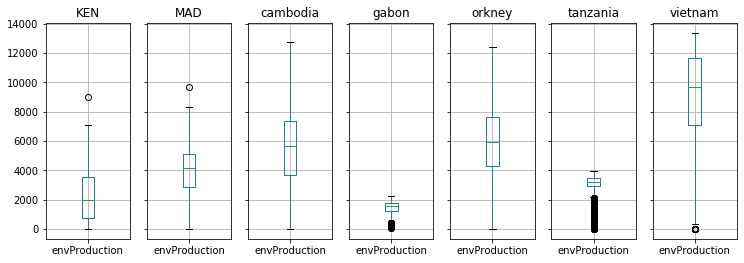

In [22]:
data[['envProduction', 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
plt.show()

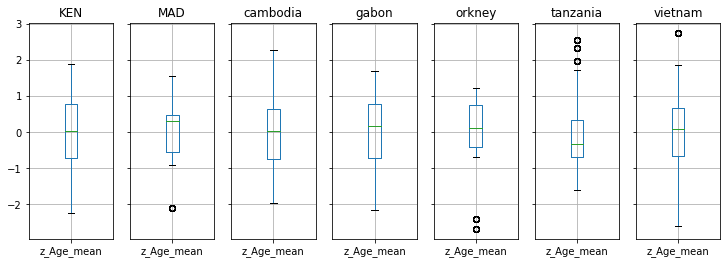

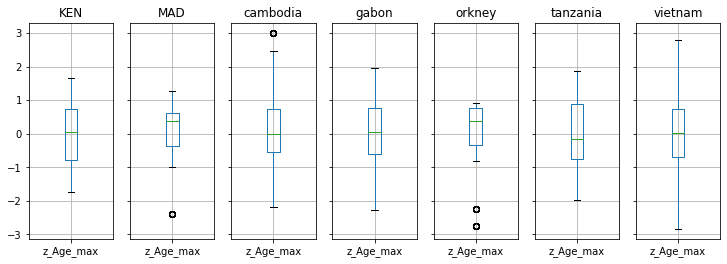

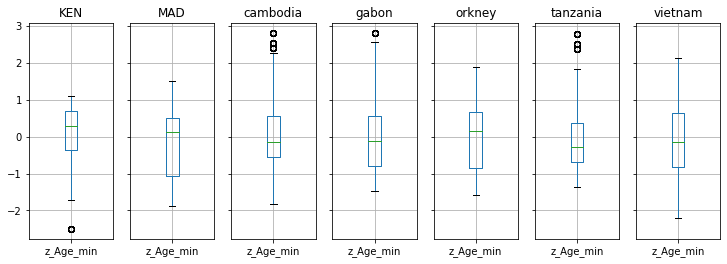

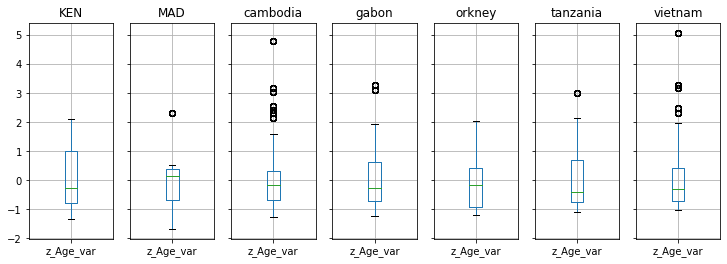

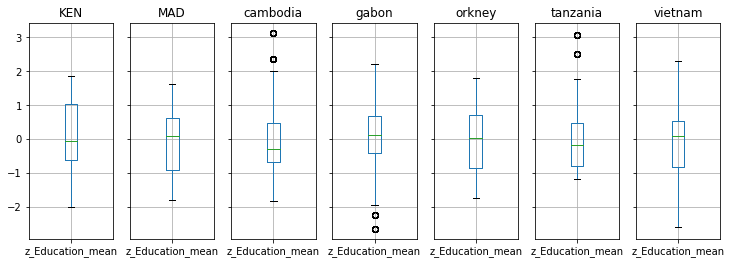

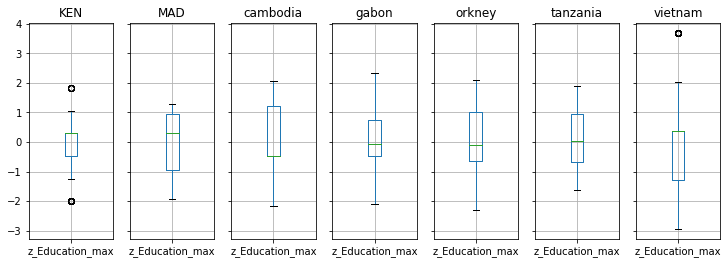

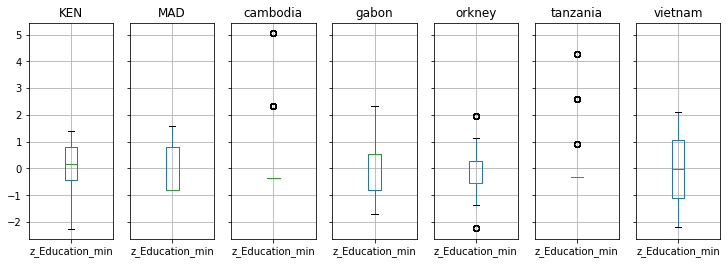

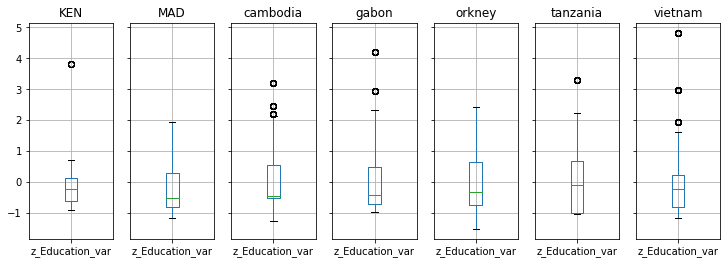

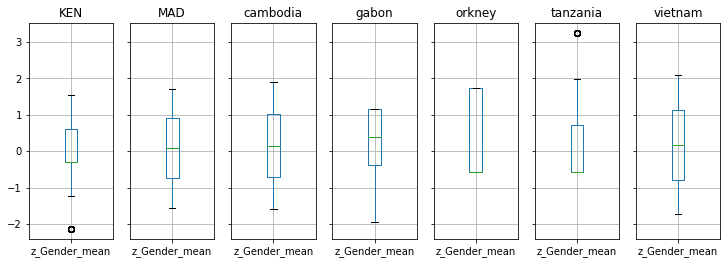

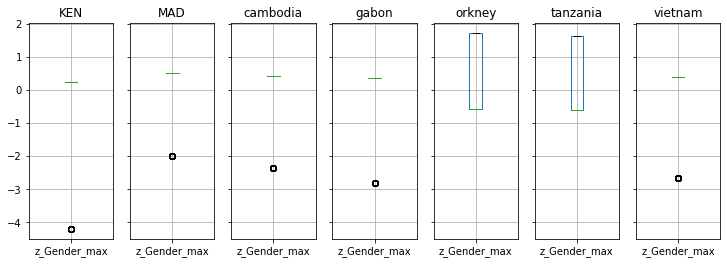

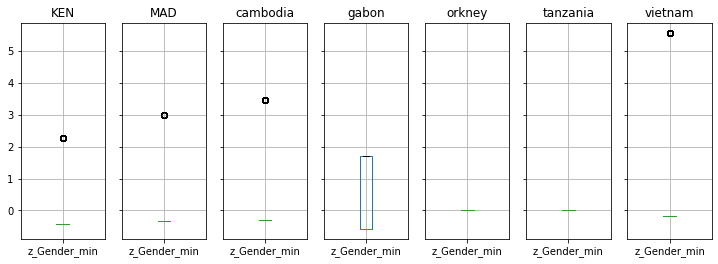

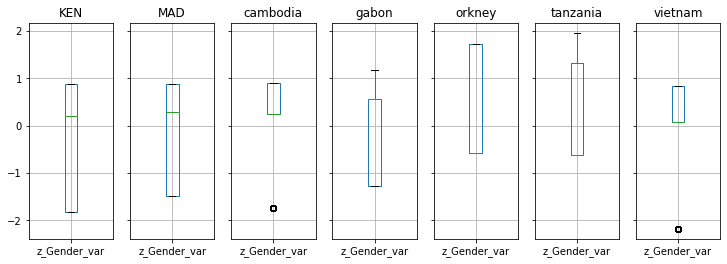

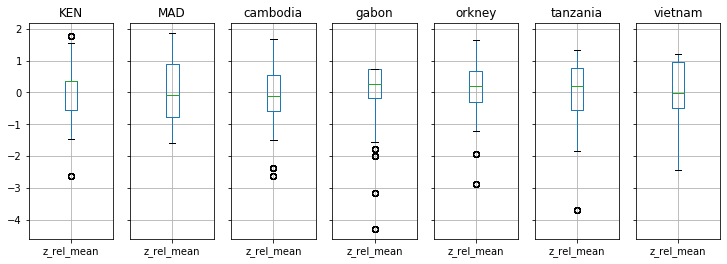

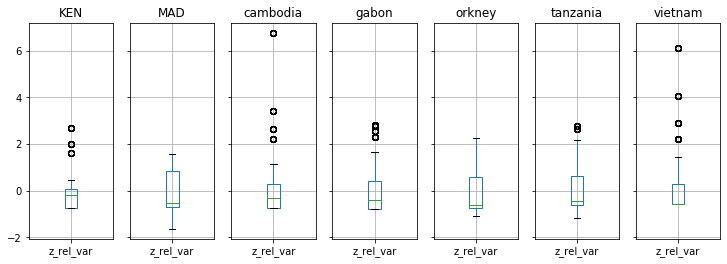

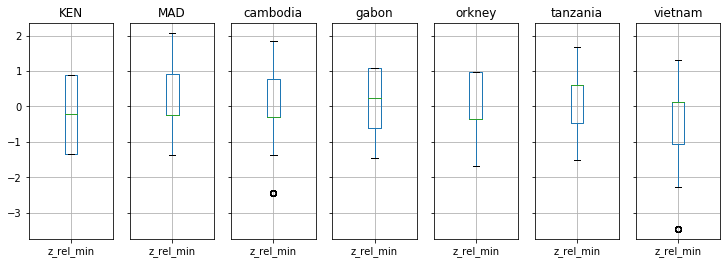

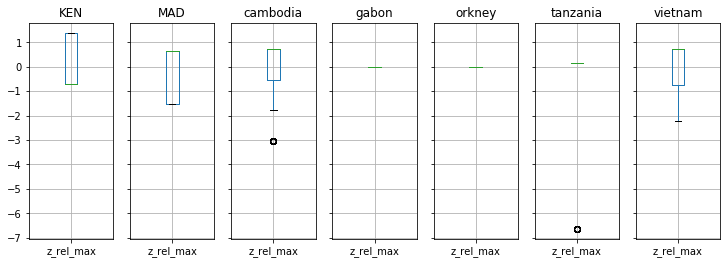

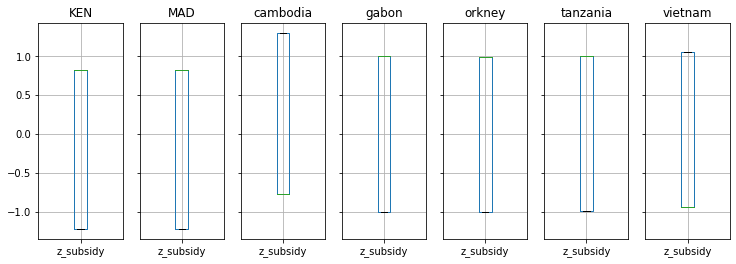

In [23]:
for var in explanatory_var:
    data[[var, 'country']].groupby('country').boxplot(figsize=(12,4), layout=(1,7))
    plt.savefig('country_'+var+'.png')
    plt.show()

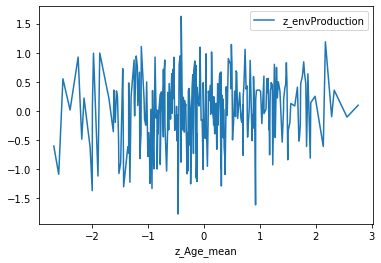

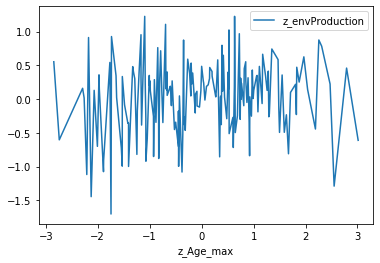

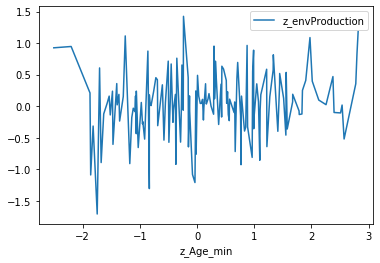

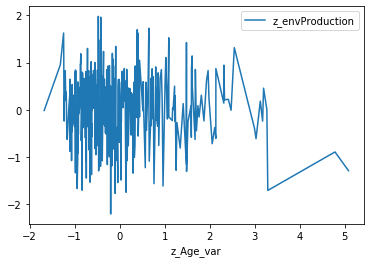

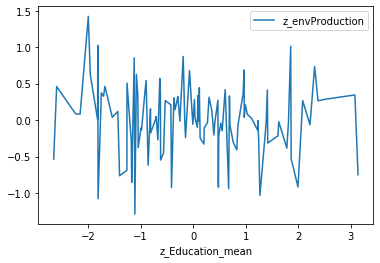

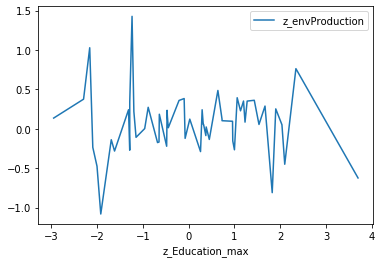

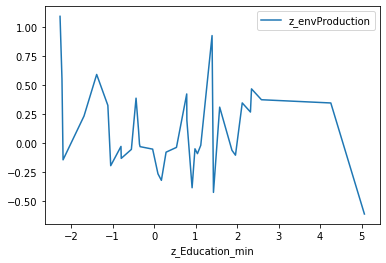

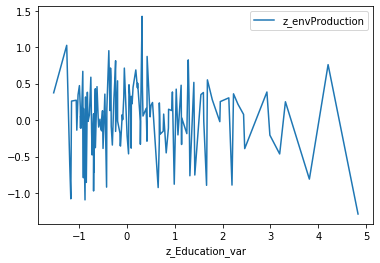

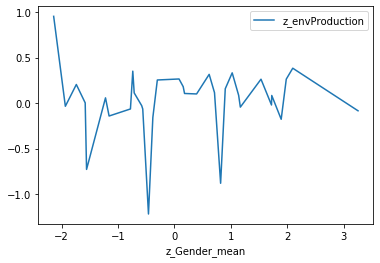

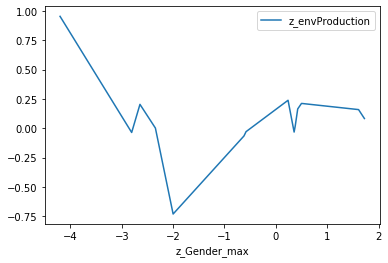

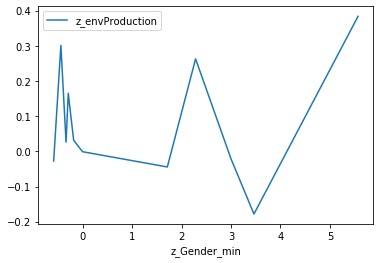

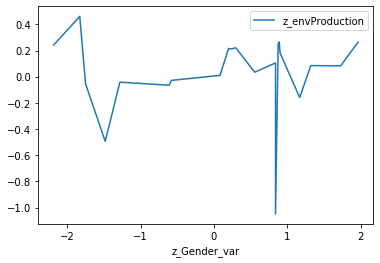

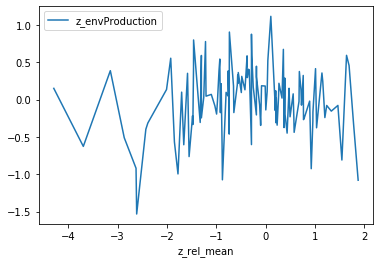

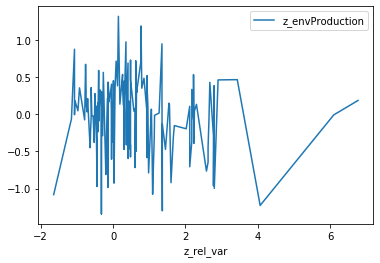

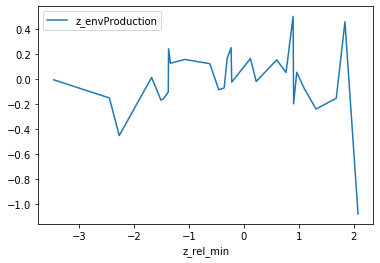

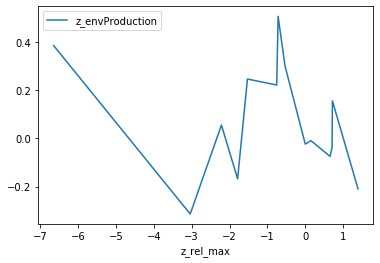

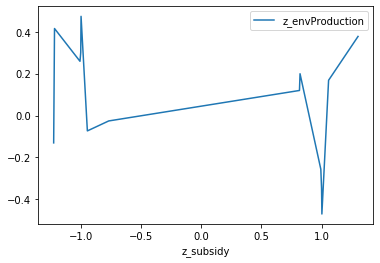

In [24]:
for var in explanatory_var:
    data[[var, 'z_envProduction']].groupby(var).mean().plot()
    plt.savefig('envprod_'+var+'.png')
    plt.show()

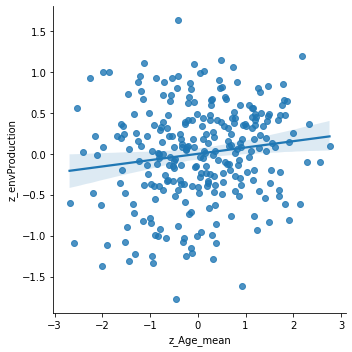

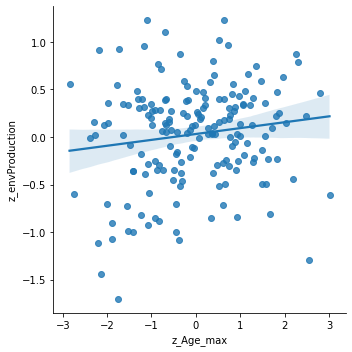

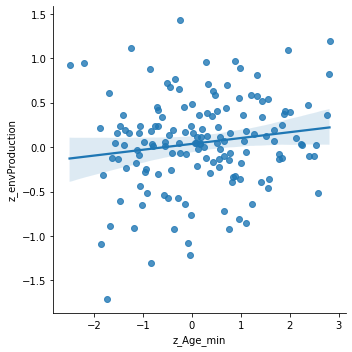

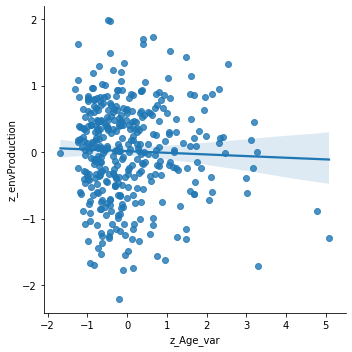

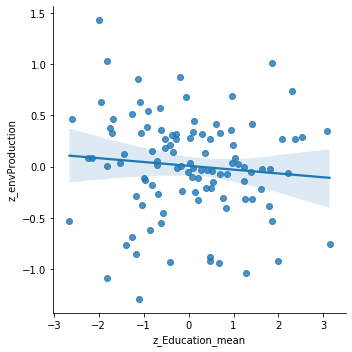

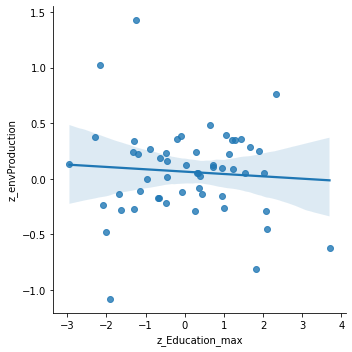

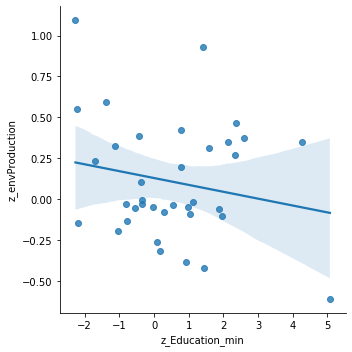

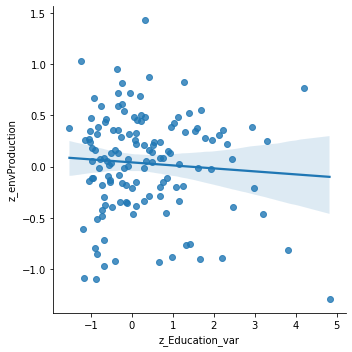

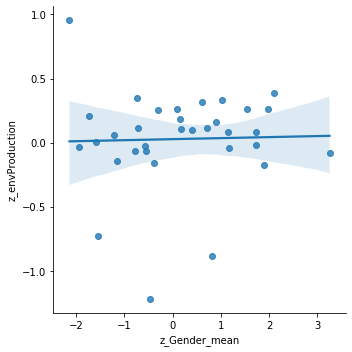

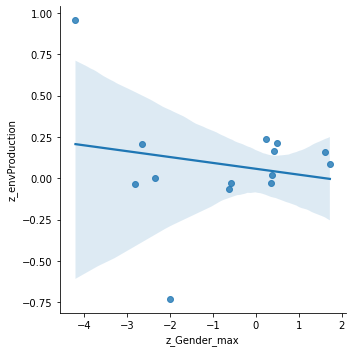

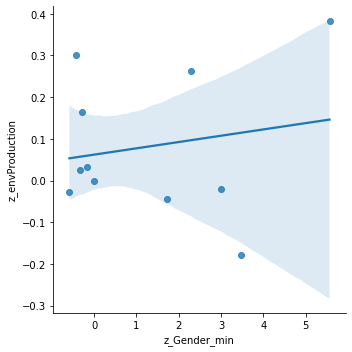

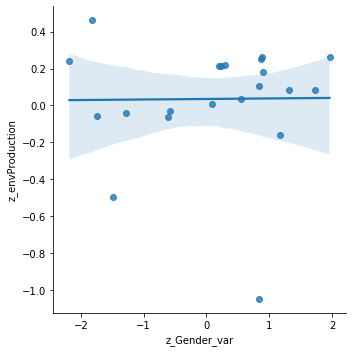

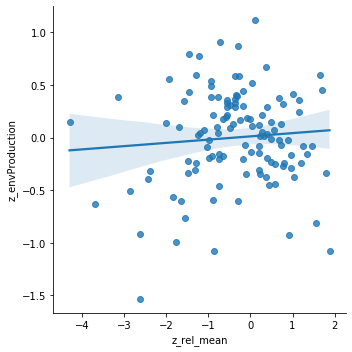

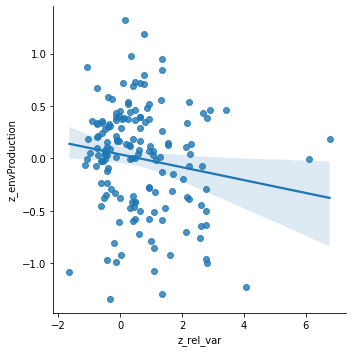

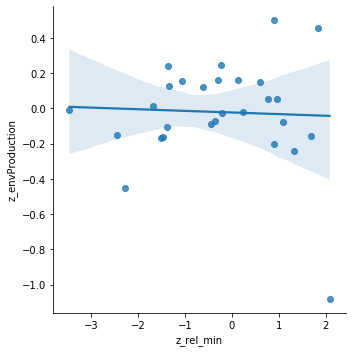

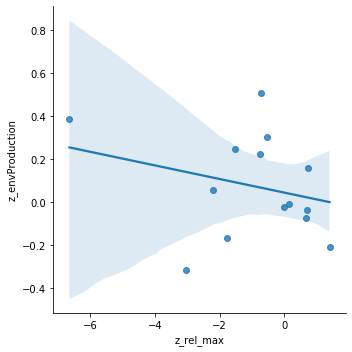

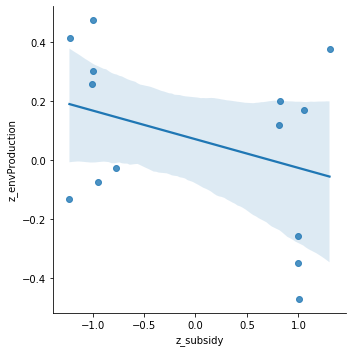

In [25]:
for var in explanatory_var:
    df = data[[var, 'z_envProduction']].groupby(var).mean().reset_index()
    sns.lmplot(x=var, y='z_envProduction', data=df, fit_reg=True) 
    plt.savefig('envprod_'+var+'.png')
    plt.show()